# Fatigue Bench

In [1]:
%load_ext autoreload
%autoreload 2

from fatigue_bench import *

### Init
Set signal duration _xf_. For _xf_ > 1000 s, _fatpack_ library will not be used.

In [2]:
xf = int(1e5)
set_xf(xf)  # Signal duration in [s]

# Graphics
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [9.5, 6]

### Metrics

Just an example, how to get moments from a spectrum:

In [3]:
# Get the spectrum
f, Gyy = get_psd_target(df=1)

# Calculate moments
moments = prob_moment.Probability_Moment(Gyy, f)

m0 = moments.momentn(0)
m1 = moments.momentn(1)
m2 = moments.momentn(2)
m4 = moments.momentn(4)
m75 = moments.momentn(0.75)
m15 = moments.momentn(1.5)

E0 = moments.E0()
EP = moments.EP()
gamma = moments.alphan(2)

# Maximum expected peak value
sigma_max = get_sigma_max_DK(f, Gyy, nbins)

### Random noise
Generate random noise, that fulfills target spectrum.

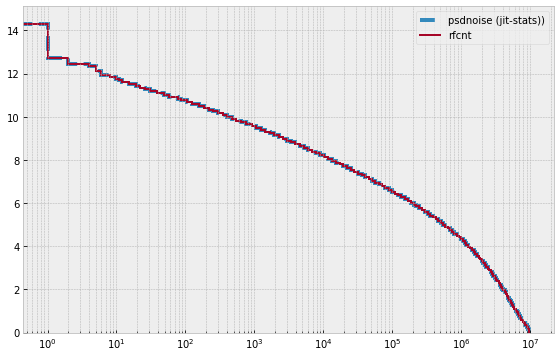

In [4]:
# Create random noise
t, y, stats = create_noise(which="psd", blend_method="cos")

# Check range pair results of just-in-time counting
check_rp_stats(y, stats)

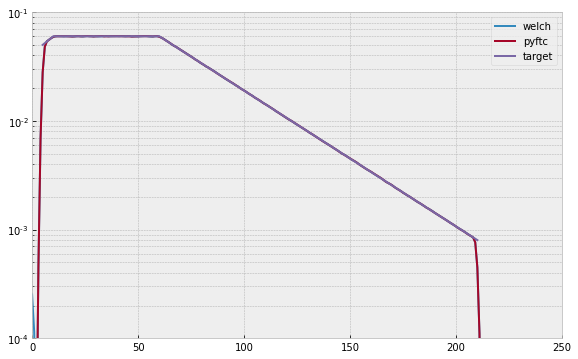

In [5]:
# Check PSD spectrum
f, Gyy = get_spectrum("welch", y, show_check=True)

### Analysis

In [6]:
si = 0.0
# sf = y.ptp()  # Peak to peak value
sf = sigma_max * 1.05 # Use Dirlik estimation
ds = sf / nbins   # Number of classes
s = np.arange(si, sf, ds)


models = dict()
for model in ["NB", "RC", "WL", "TB", "AL", "DK", "ZB", "RF", "RFC"]:
    res = model_results(model, y, f, Gyy, s)
    if not res:
        models[model] = None
        continue
    models[model] = dict()
    models[model]["life"] = res.Life()
    models[model]["lifes"] = res.Lifes()
    models[model]["S"] = s
    if model in ("RF", "RFC"):
        S, nRF, pRF = res.rainflow_histogram()
        models[model]["hist"] = dict(S= S, n = nRF, p = pRF)
        models[model]["pdf"] = pRF
        models[model]["damage"] = res.Damage()
        models[model]["counts"] = nRF
        models[model]["S"] = S
    elif model == "WL":
        models[model]["pdf"] = None
        models[model]["damage"] = None
        models[model]["counts"] = None
    else:
        models[model]["pdf"] = res.PDF()
        models[model]["damage"] = res.Damage()
        models[model]["counts"] = res.counting_cycles()

### Range pair counting

In [7]:
# Helper funtion
def plot_counts(ds, fmt=None, *, cumulated=False, turned=False, **kwargs):
    "Draw histogram for (cumulated) counts"
    s = ds["S"]
    n = ds["counts"]
    if cumulated:
        n = np.cumsum(n[::-1])[::-1]
    i = np.argwhere(n > 1).item(-1)
    s = s[:i+2]
    n = n[:i+2]
    if turned:
        args = [n, s]
    else:
        args = [s, n]

    if fmt:
        args.append(fmt)

    plt.plot(*args, **kwargs)

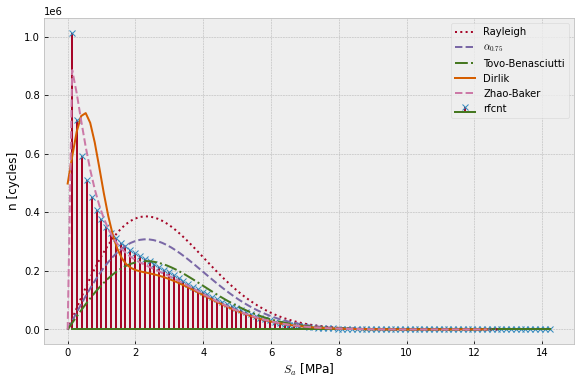

In [8]:
# Comparisation
plt.figure("Comparison of counts in same plot")
if models["RF"]:
    plt.stem(models["RF"]["S"], models["RF"]["counts"], linefmt="C0-", markerfmt="o", label="fatpack")
plt.stem(models["RFC"]["S"], models["RFC"]["counts"], linefmt="C1-", markerfmt="x", label="rfcnt")
plot_counts(models["NB"], linestyle=':', label="Rayleigh")
plot_counts(models["AL"], linestyle='--', label = r"$\alpha_{0.75}$")
plot_counts(models["TB"], linestyle='-.', label="Tovo-Benasciutti")
plot_counts(models["DK"], linestyle='-', label="Dirlik")
plot_counts(models["ZB"], linestyle='--', label="Zhao-Baker")

plt.legend()

plt.xlabel(r'$S_{a}$ [MPa]')
plt.ylabel(r'n [cycles]')
plt.grid(True)

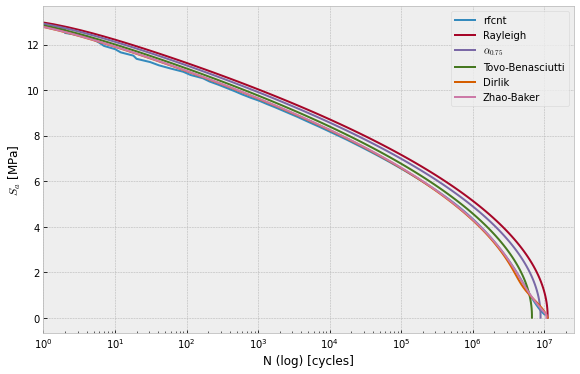

In [9]:
# Comparisation (cumulative)
plt.figure("Comparison of cumulative results in same plot")
if models["RF"]:
    plot_counts(models["RF"], 'k-', cumulated=True, turned=True, label="fatpack")
plot_counts(models["RFC"], cumulated=True, turned=True, label="rfcnt")
plot_counts(models["NB"], cumulated=True, turned=True, label="Rayleigh")
plot_counts(models["AL"], cumulated=True, turned=True, label=r"$\alpha_{0.75}$")
plot_counts(models["TB"], cumulated=True, turned=True, label="Tovo-Benasciutti")
plot_counts(models["DK"], cumulated=True, turned=True, label="Dirlik")
plot_counts(models["ZB"], cumulated=True, turned=True, label="Zhao-Baker")

plt.legend()
plt.xlabel(r'N (log) [cycles]')
plt.ylabel(r'$S_{a}$ [MPa]')
plt.grid(True)
plt.xscale('log')
_ = plt.xlim([1, None])

### Fatigue responses

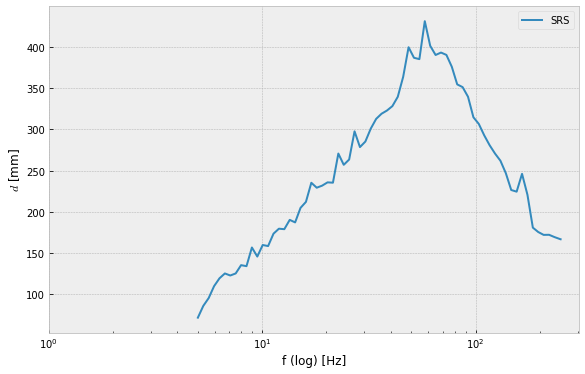

In [10]:
# Shock response
rf = RainflowTest(C, k, y, x=1)  # For wl params only
wl = dict(wl_nd=rf.wl["nd"], wl_sd=rf.wl["sd"], wl_k=rf.wl["k"])
res = get_srs_frs(y * constants.g, fs, 5, 250, wl)
if res:
    from pyftc import random_noise_transforms as rnt
    (f, srs, frs) = res
    plt.figure("Shock response spectrum")
    plt.plot(f, srs, label="SRS")
    if 0:
        f, Gyy = get_psd_target(df=1)
        ers = rnt.erf_from_psd(f, Gyy, D_EMS=0.05, T=xf)
        plt.plot(f, ers, label="ERS")

    plt.legend()
    plt.xlabel(r'f (log) [Hz]')
    plt.ylabel(r'$d$ [mm]')
    plt.grid(True)
    plt.xscale('log')
    _ = plt.xlim([1, None])

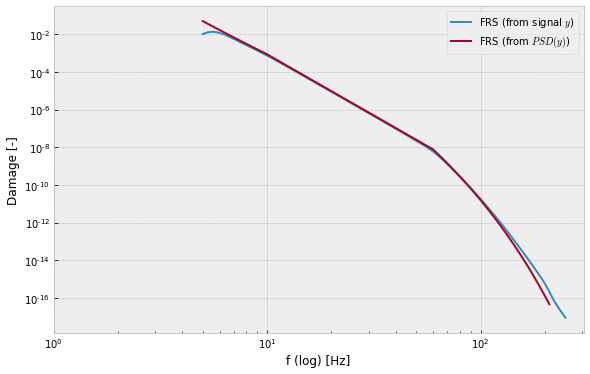

In [11]:
# Fatigue response
f, Gyy = get_spectrum("welch", y)

if res:
    (f, srs, frs) = res
    plt.figure("Fatigue response spectrum")
    plt.plot(f, frs, label="FRS (from signal $y$)")

    if 1:
        f, Gyy = get_psd_target(df=1)
        frs = rnt.frs_from_psd(f, Gyy, C, k, D_EMS=0.05, wl=wl, df=1, T=xf)
        plt.plot(f, frs, label="FRS (from $PSD(y)$)")

    plt.legend()
    plt.xlabel(r'f (log) [Hz]')
    plt.ylabel(r'Damage [-]')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    _ = plt.xlim([1, None])

In [12]:
def transmissibility(w, wn, D_EMS):
    omega = w / wn
    k1 = (2 * D_EMS * omega)**2
    nom = 1 + k1
    den = (1 - omega**2)**2 + k1

    return np.sqrt(nom / den)


C:\Users\Andi\AppData\Local\Temp\ipykernel_7660\3191729571.py:2: RuntimeWarning: divide by zero encountered in true_divide
  omega = w / wn
C:\Users\Andi\AppData\Local\Temp\ipykernel_7660\3191729571.py:2: RuntimeWarning: invalid value encountered in true_divide
  omega = w / wn
C:\Users\Andi\AppData\Local\Temp\ipykernel_7660\3191729571.py:7: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(nom / den)


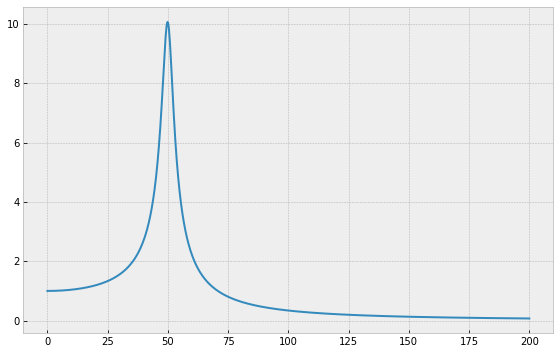

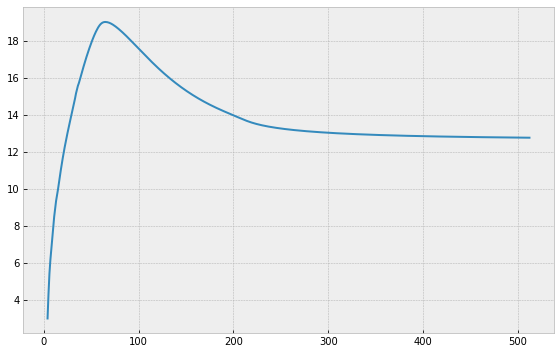

In [13]:
xf = 1000
f = np.linspace(0, 200, 1000)
Gyy = transmissibility(f, 50, 0.05)
plt.figure()
plt.plot(f, Gyy)

sigma_max = 700
s = np.linspace(0, sigma_max, nbins)

f, Gyy = get_spectrum("welch", y)
S = np.zeros(len(f))
for i, fi in enumerate(f):
    tgyy = transmissibility(f, fi, 0.05)
    S[i] = get_sigma_max_DK(f, Gyy * tgyy, nbins)

plt.figure()
plt.plot(f, S)

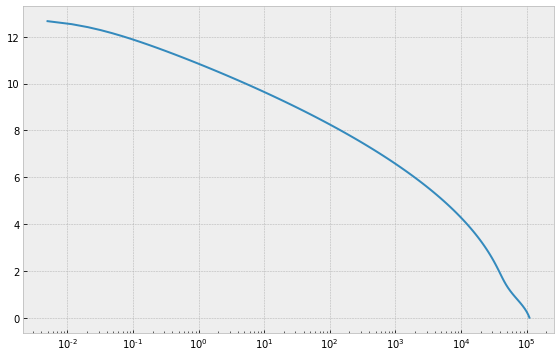

In [14]:
f, Gyy = get_psd_target(df=1)
sigma = get_sigma_max_DK(f, Gyy, nbins)
s = np.linspace(0, sigma, nbins)
ds = s[1]
model = Dirlik.DK(k, C, Gyy, f, xf, s)
n = model.counting_cycles()
n = np.cumsum(n[::-1])[::-1]
plt.plot(n, s)
plt.xscale("log")